# AI political Fake News Detector

### Importação das bibliotecas

In [69]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st
from scipy.sparse import hstack, csr_matrix

import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')

# Import date class from datetime module
from datetime import date

import string
#usado para ler arquivos dentro do zip

from zipfile import ZipFile
import json

import random

In [70]:
import tensorflow as tf
from tensorflow import keras
#import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Dropout, BatchNormalization, GlobalMaxPooling1D, GlobalMaxPool1D, SpatialDropout1D, Conv1D

from keras.optimizers import SGD
from keras.callbacks import TensorBoard
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint

from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec

from sklearn.manifold import TSNE

from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve


import os

import seaborn as sns
%matplotlib inline

In [71]:
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *

nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
#Precisamos garantir que temos um corpus de stopwords na nossa máquina.
#Por isso, fazemos o download desses dados.
#nltk.download("stopwords")


In [73]:
#HOJE = date.today()
HOJE=""
print(f"Hoje é {HOJE}! ")

Hoje é ! 


### Configuração da Autenticação no Google drive para o uso dos arquivos csv

In [74]:
# Code to read csv file into Colaboratory:!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#1. <strong>Análise Exploratória do Dataset</strong>

> Bloco com recuo




### 1.1 Download do dataset a partir do drive

In [75]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

COLAB_DIR="gdrive/My Drive/Colab Notebooks/"
WORK_DIR=f"{COLAB_DIR}/Experimento 2024.1"
#!ls "{WORK_DIR}"

Mounted at /content/gdrive


In [76]:
DATASET_FILE=f'{WORK_DIR}/data/all.zip'

### 1. 2 Verificando os Arquivos do dataset

In [77]:
#Arquivo zip
zip_file = ZipFile(f'{DATASET_FILE}')

for f in zip_file.infolist():
  print(f"Arquivo: {f.filename}")


Arquivo: all/pre-processed.csv
Arquivo: all/sample.csv


In [78]:
#Criar um dicionario de dataframes com nomes de arquivo como chaves
#{"file.csv":df}
dic_csvFile_df = {f.filename: pd.read_csv(zip_file.open(f.filename))
        for f in zip_file.infolist()
            if f.filename.endswith('.csv') or  f.filename.endswith('.CSV')}

Exception ignored in: <function ZipFile.__del__ at 0x7b43209a4820>
Traceback (most recent call last):
  File "/usr/lib/python3.10/zipfile.py", line 1821, in __del__
  File "/usr/lib/python3.10/zipfile.py", line 1843, in close
  File "/usr/lib/python3.10/zipfile.py", line 1943, in _fpclose
OSError: [Errno 107] Transport endpoint is not connected


In [79]:
dic_csvFile_df.keys()

dict_keys(['all/pre-processed.csv', 'all/sample.csv'])

In [80]:
all_df=pd.read_csv(f'{WORK_DIR}/data/merged.csv',sep=';')
sample_df=pd.read_csv(f'{WORK_DIR}/data/sample.csv',sep=';')

train_df=pd.read_csv(f'{WORK_DIR}/data/dataset-fakenews.CSV',sep=';')

In [81]:
# Arquivo de treinamento
#all_df=dic_csvFile_df["all/pre-processed.csv"]
train_df= all_df
train_df.tail(2)

,index,label,preprocessed_news
7299,8049,fake,"Em meio às enchentes no RS, o Ibama barrou os..."
7300,8050,fake,A tentativa dos moradores de abrir uma estrad...


In [82]:
sample_df.head(10)

,index,label,preprocessed_news
0,1,label,O aquecimento global não é causado pelo homem....
1,2,False,Ibama impediu moradores de abrir estrada no RS...
2,3,True,As enchentes ocorridas no Rio Grande do Sul sã...
3,4,False,A redução recente de homícios foi causada pelo...
4,5,True,O aborto é previsto em lei desde 1940 quando h...
5,6,False,"O empresário Luciano Hang, dono da Havan, env..."
6,7,True,PF conseguiu imagens ineditas de joias ilegais...
7,8,False,Governo do presidente Lula (PT) legalizou o ab...
8,9,True,Irmão do Janja virou coordernador de prefeita ...
9,10,True,Justiça do DF torna Jair Renan Bolsonaro réu p...


Como df_test e df_submit têm os mesmos id, fazemos o merge dos dois

### Percentagem do test em relação ao treinamento

## 1.4. Quantas classes?
* São duas classes

In [83]:
train_df['label'].unique()

array(['fake', 'true', nan], dtype=object)

Transformar label em números

In [84]:
def labelToNumber(row):
  if str(row['label'])=='fake':
    return 1
  if str(row['label'])=='Fake':
    return 1
  if str(row['label'])=='FAKE':
    return 1
  if str(row['label'])=='false':
    return 1
  if str(row['label'])=='False':
    return 1
  if str(row['label'])=='FALSE':
    return 1
  return 0

train_df['label_number']= train_df.apply(lambda row: labelToNumber(row), axis=1)
sample_df['label_number']= sample_df.apply(lambda row: labelToNumber(row), axis=1)
train_df

,index,label,preprocessed_news,label_number
0,0,fake,katia abreu diz vai colocar expulsao moldura n...,1
1,1,fake,ray peita bolsonaro conservador fake entrevist...,1
2,2,fake,reinaldo azevedo desmascarado policia federal ...,1
3,3,fake,relatorio assustador bndes mostra dinheiro pub...,1
4,4,fake,radialista americano fala sobre pt vendem ilus...,1
...,...,...,...,...
7296,8046,fake,"Durante a crise das enchentes no RS, o Ibama ...",1
7297,8047,fake,Moradores do RS foram bloqueados pelo Ibama a...,1
7298,8048,fake,O Ibama impediu a construção de uma estrada p...,1
7299,8049,fake,"Em meio às enchentes no RS, o Ibama barrou os...",1


In [85]:
#Autores únicos
#len(train_df['author'].unique())

## 1.5 Campos nulos: percentagem das instâncias com uma determinada coluna com valor nulo
* Polo resultado do código abaixo. 9% de autores não apresentam autor

In [86]:
def verPercentualVazioPorCampo(df):
  return round(df.isnull().sum()*100/df.shape[0])

verPercentualVazioPorCampo(train_df)

index                0.0
label                0.0
preprocessed_news    0.0
label_number         0.0
dtype: float64

In [87]:
"""
#Percentafem de noticias sem author que são fake:
df = train_df[(train_df['preprocessed_news'].isnull())]
qde_sem_autor=df.shape[0]
df= df[df['label']==1]
qde_Fake_sem_autor=df.shape[0]
perc = qde_Fake_sem_autor*100/qde_sem_autor
print(f'{round(perc)} %')

"""

"\n#Percentafem de noticias sem author que são fake:\ndf = train_df[(train_df['preprocessed_news'].isnull())]\nqde_sem_autor=df.shape[0]\ndf= df[df['label']==1]\nqde_Fake_sem_autor=df.shape[0]\nperc = qde_Fake_sem_autor*100/qde_sem_autor\nprint(f'{round(perc)} %')\n\n"

### Concatenar Train e Test.
Isso agiliza os tratatmentos. Em vez de tratar em 2 conjuntos. Tratamos um e depois separamos de no.

## <b>1.6  Nuvem de palavras sobre tópicos do dataset</b>

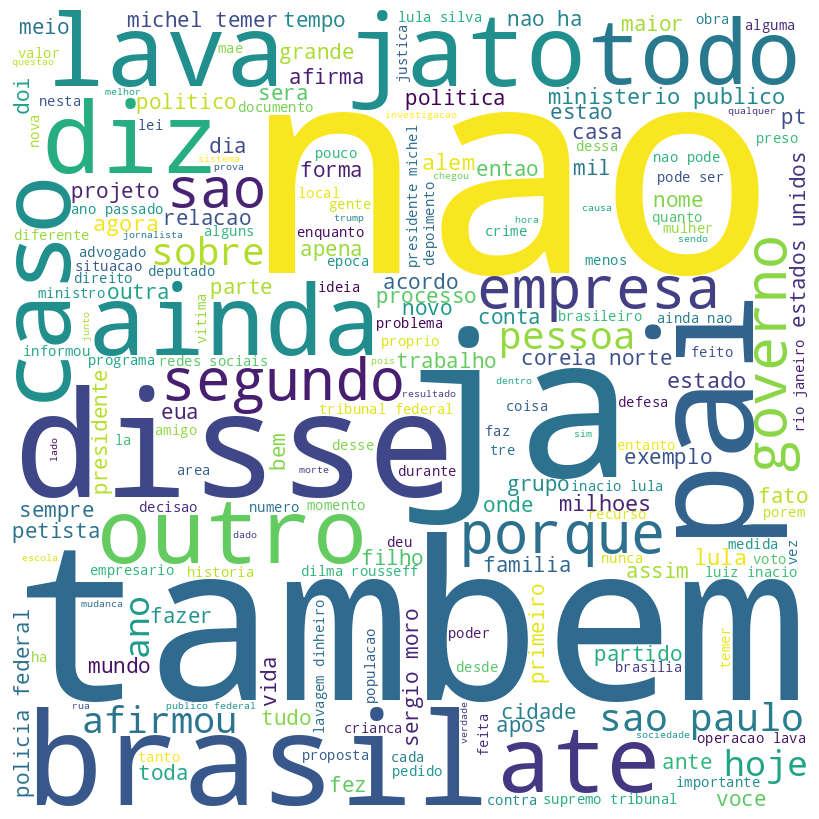

In [88]:
comment_words = ''

#cloudStopwords =

# iterate through the csv file
for val in train_df.preprocessed_news:

	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()

	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()

	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = STOPWORDS,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig('nuvem.png',dpi=200, format='png', bbox_inches='tight')

plt.show()

# <strong> 3. Experimentos </strong>
\begin{array}{c} \hline
Modelo & Acurácia & Custo & Estratégia \\ \hline
Exp 1: & 70\% & V & Train:80\% - Val:20\% \\
foo & bar & foo & bar \\
foo & bar & foo & bar \\
foo & bar & foo & bar \\
foo & bar & foo & bar \\ \hline
\end{array}

In [89]:
#Definição de alguns hyperparametros

#Quantidade de palavras do vocabulário
VOCAB_SIZE = 30000

#Quantuidade de palavras por instância
SEQUENCE_LEN=256

EMBED_DIM=256

n_dim=64

PAD_TYPE='post' # or 'pre'

TRUNCATE_TYPE='post'

n_dense=128

n_filter=128

n_kernel=3

n_dim=64

BATCH_SIZE = 32

EPOCHS = 5

## Engenharia de features com uso de NLP
* Converter para miniscúlas
* Remover stop words e pontuações
* Tokenização
* Vetorização dos tokens (Embidding Layer)


In [90]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *

nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [91]:
#Converting All Characters to Lowercase
def processNaturalLanguage(row):
  """Converter em minusculo."""

  index= 'ind'+str(row.name)+'ex'
  text=str(index)+' '+str(row['preprocessed_news'])

  text= removePontuation(str(text).lower())

  text=removePontuation(str(" "+text).lower())

  return removerSTPWORDS(text)

def removePontuation(content):
  """Punctuation pelo espaço """

  stpwrds =  list(string.punctuation) +['\n', '.']
  sentence=content
  for p in stpwrds:
    sentence= sentence.replace(p," ")

  return sentence.replace('\n', ' ')

def removerSTPWORDS(content):
  """ Removing Stop Words """

  stpwrds = stopwords.words('english')

  text=''

  tokens= content.split(' ')

  for token  in tokens:

    word= token.lower()

    #print(f'word ={word}')

    if word in stpwrds:

      #substituir por espaço em branco
      text=text+ ' '

      continue
    text=text+ ' ' + word

  return text

#Teste da função
content="This is for testing proposen only. of an testing teste. Good par ce. Don't. \nTestes"
removerSTPWORDS(removePontuation(content))

'    testing proposen     testing teste  good par ce      testes'

In [92]:
x_text = train_df.apply(lambda row: processNaturalLanguage(row), axis=1)
y = train_df['label_number']
x_text

0         ind0ex katia abreu diz vai colocar expulsao ...
1         ind1ex ray peita bolsonaro conservador fake ...
2         ind2ex reinaldo azevedo desmascarado policia...
3         ind3ex relatorio assustador bndes mostra din...
4         ind4ex radialista americano fala sobre pt ve...
                              ...                        
7296      ind7296ex  durante  crise das enchentes  rs ...
7297      ind7297ex  moradores  rs foram bloqueados pe...
7298      ind7298ex   ibama impediu  construção de uma...
7299      ind7299ex  em meio às enchentes  rs   ibama ...
7300      ind7300ex   tentativa dos moradores de abrir...
Length: 7301, dtype: object

In [93]:
x_text_sample = sample_df.apply(lambda row: processNaturalLanguage(row), axis=1)
y_sample = sample_df['label_number']
#x_text_sample


In [94]:
#y_sample

In [95]:
train_df['features']= train_df.apply(lambda row: processNaturalLanguage(row), axis=1)

sample_df['features']= sample_df.apply(lambda row: processNaturalLanguage(row), axis=1)

In [96]:
train_df.head(2)

,index,label,preprocessed_news,label_number,features
0,0,fake,katia abreu diz vai colocar expulsao moldura n...,1,ind0ex katia abreu diz vai colocar expulsao ...
1,1,fake,ray peita bolsonaro conservador fake entrevist...,1,ind1ex ray peita bolsonaro conservador fake ...


In [97]:
train_df['length']= train_df.apply(lambda row: len(str(row['preprocessed_news'])), axis=1)

In [98]:
train_df.head()

,index,label,preprocessed_news,label_number,features,length
0,0,fake,katia abreu diz vai colocar expulsao moldura n...,1,ind0ex katia abreu diz vai colocar expulsao ...,693
1,1,fake,ray peita bolsonaro conservador fake entrevist...,1,ind1ex ray peita bolsonaro conservador fake ...,1072
2,2,fake,reinaldo azevedo desmascarado policia federal ...,1,ind2ex reinaldo azevedo desmascarado policia...,1194
3,3,fake,relatorio assustador bndes mostra dinheiro pub...,1,ind3ex relatorio assustador bndes mostra din...,2917
4,4,fake,radialista americano fala sobre pt vendem ilus...,1,ind4ex radialista americano fala sobre pt ve...,467


In [99]:
train_df['length'].describe()

count     7301.000000
mean      2789.604438
std       2938.472382
min          3.000000
25%        674.000000
50%       1548.000000
75%       4026.000000
max      32759.000000
Name: length, dtype: float64

In [100]:
train_df['words_number']= train_df.apply(lambda row: len(str(row['preprocessed_news']).split(' ')), axis=1)
train_df.head(10)

,index,label,preprocessed_news,label_number,features,length,words_number
0,0,fake,katia abreu diz vai colocar expulsao moldura n...,1,ind0ex katia abreu diz vai colocar expulsao ...,693,99
1,1,fake,ray peita bolsonaro conservador fake entrevist...,1,ind1ex ray peita bolsonaro conservador fake ...,1072,143
2,2,fake,reinaldo azevedo desmascarado policia federal ...,1,ind2ex reinaldo azevedo desmascarado policia...,1194,153
3,3,fake,relatorio assustador bndes mostra dinheiro pub...,1,ind3ex relatorio assustador bndes mostra din...,2917,339
4,4,fake,radialista americano fala sobre pt vendem ilus...,1,ind4ex radialista americano fala sobre pt ve...,467,66
5,5,fake,willian waack continuara internado sirio liban...,1,ind5ex willian waack continuara internado si...,471,56
6,6,fake,problema cardiaco tira william waack jornal gl...,1,ind6ex problema cardiaco tira william waack ...,504,66
7,7,fake,edir macedo podera disputar eleicoes presidenc...,1,ind7ex edir macedo podera disputar eleicoes ...,991,130
8,8,fake,boechat sobre lula alma pode ser honesta gover...,1,ind8ex boechat sobre lula alma pode ser hone...,264,41
9,9,fake,pt diz lula nao dinheiro sobreviver chama moro...,1,ind9ex pt diz lula nao dinheiro sobreviver c...,736,102


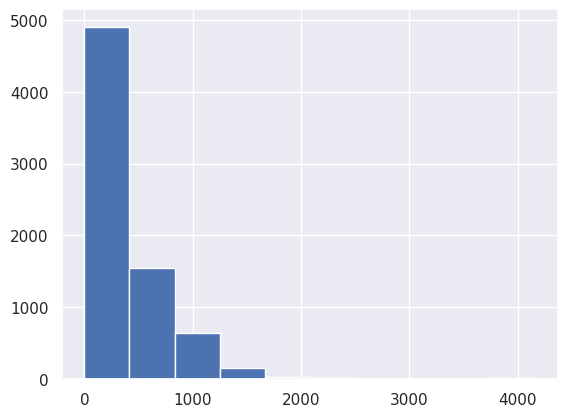

In [101]:
words_numberList=train_df['words_number']

x = np.random.normal(words_numberList)

plt.hist(x)
plt.show()

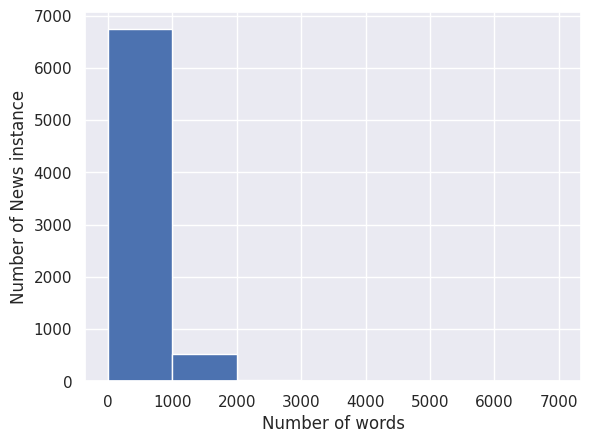

In [102]:
plt.hist(x, bins=[0,1000, 2000,3000,4000,5000, 6000, 7000])
plt.xlabel('Number of words')
plt.ylabel('Number of News instance')
plt.show()

In [103]:
train_df['words_number'].describe()

count    7301.000000
mean      361.624298
std       378.399274
min         1.000000
25%        90.000000
50%       202.000000
75%       521.000000
max      4164.000000
Name: words_number, dtype: float64

In [104]:
train_df['length'].describe()

count     7301.000000
mean      2789.604438
std       2938.472382
min          3.000000
25%        674.000000
50%       1548.000000
75%       4026.000000
max      32759.000000
Name: length, dtype: float64

In [105]:


words_numberList

0        99
1       143
2       153
3       339
4        66
       ... 
7296     18
7297     16
7298     18
7299     18
7300     18
Name: words_number, Length: 7301, dtype: int64

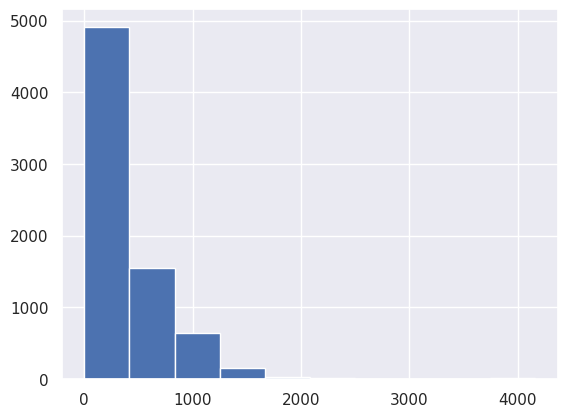

In [106]:
plt.hist(words_numberList)
plt.show()

In [107]:
#x_text = train_df['features']
#y = train_df['label_number']
#x_text

In [108]:
x_text.head(5)

0      ind0ex katia abreu diz vai colocar expulsao ...
1      ind1ex ray peita bolsonaro conservador fake ...
2      ind2ex reinaldo azevedo desmascarado policia...
3      ind3ex relatorio assustador bndes mostra din...
4      ind4ex radialista americano fala sobre pt ve...
dtype: object

In [109]:
print(f"Verificar quantidades de instâncias. Entradas: {x_text.shape}.  Saída: {y.shape}")

Verificar quantidades de instâncias. Entradas: (7301,).  Saída: (7301,)


#### Tokenização e vetorização dos tokens (One-Hot)

In [110]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)

tokenizer.fit_on_texts(x_text)

sequences = tokenizer.texts_to_sequences(x_text)

sequences_sample = tokenizer.texts_to_sequences(x_text_sample)

sequences = pad_sequences(sequences, padding=PAD_TYPE, truncating=TRUNCATE_TYPE, maxlen=SEQUENCE_LEN)

sequences_sample = pad_sequences(sequences_sample, padding=PAD_TYPE, truncating=TRUNCATE_TYPE, maxlen=SEQUENCE_LEN)

In [111]:
sequences[0]

array([ 3739,  2412,    22,    27,   834,  5618, 29726,     1,  6009,
        1358,  3739,  2412,     7,  5618,   197,   544,   115,  1427,
         370,  1738,    15, 10303,  2183,   475,  6678, 29726, 15942,
        5618,    35,   988,    69,  1028,  8082,   395,  1891,  5729,
          24, 15266,     1,  5619,    19,  5619,    19,   989,  1525,
           7,  3739,  2412,  6954,  5618,   344,   319,   452,  5729,
        2987,  3739,  2094,   919,  1614,  3739,     1,   176,    68,
         122,    10,   599, 26671,   596,    68,  6186,  3739,   524,
        6861,   179,   197, 20878,   648,  4087,  3739,   386,  6266,
       22431,    53,  8364,   106,    18,    97,    68,     1,  3739,
        2412, 17569,   166, 15267,  1559,    39,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [112]:
#sequences_sample[0]

In [113]:
#index  de algumas palavras no dicionario 'word_index' do objeto Tokenizer
words = ['lula', 'trump', 'bolsonaro', 'virus', 'poder','janja','aquecimento']
for word in words:
  print('{}: {}'.format(word, tokenizer.word_index[word]))

lula: 2
trump: 138
bolsonaro: 448
virus: 1094
poder: 131
janja: 19611
aquecimento: 4958


In [114]:
#dicionario palavra com seu indice
word_index = tokenizer.word_index

word_index["PAD"]=0

#gerar o dicionario reverso que armazena: o indice apontando para a palavra
index_word = {index:word for word,index in word_index.items()}

In [115]:
word_index['PAD']

0

In [116]:
index_word[2]

'lula'

In [117]:
words_index_keys= list(word_index.keys())

for i in range(2):
  key=words_index_keys[i]
  i+=1
  print(key)

nao
lula


In [118]:
if( 'lula' in list(word_index.keys())) :
  print('ok')

ok


### Reconstruir o texto a partir dos index das palavras (tokens)
Escolhemos qualquer instâncau

In [119]:
' '.join(index_word[id] for id in sequences[55])

'lobao ataca gil rico virou ministro cultura ficou cantor lobao nao papas lingua concedeu entrevista radio jovem pan atacou cultura gilberto gil ninguem esperava lobao vai tomar processo daqueles musico acusou gilberto gil ter enriquecido durante governos petistas disse ministro cultura anos ai abriram gil comecou rico ministerio acabou lobao exagerou provavelmente fumou alguma coisa estragada PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD

In [120]:
len((' '.join(index_word[id] for id in sequences[55])).split(' '))

256

Configurações finais das features dos modelos

In [121]:
def obterFeatures():
  X=sequences

  random_seed=random.randrange(train_df.shape[0])

  return train_test_split( X, y, test_size=0.2, random_state=random_seed)

X_train, X_val, y_train, y_val = obterFeatures()

In [122]:
X_train

array([[  586,  6815,     1, ...,  4885,    50,    38],
       [  316,  6276,  5800, ...,    51,   410,   338],
       [  435,  1119,   594, ...,    78,   318,    47],
       ...,
       [ 1892,  6958, 16032, ...,     0,     0,     0],
       [ 1077, 10841,  4830, ...,     0,     0,     0],
       [11937,   625,    42, ...,  1611,   560,  1299]], dtype=int32)

Aplicar

In [123]:
X_train, X_val, y_train, y_val = obterFeatures()

In [124]:

#!ls "{COLAB_DIR}"

In [125]:
RESULTS_DIR=f"{WORK_DIR}/Results"
#!ls "{WORK_DIR}"

## <strong>Experimento 1: Rede Densa com 2 Camadas Ocultas </strong>
* Acurácia esperada: 70%

In [126]:
histDic={}

In [127]:
def gerarGraficoAcuracia(hist, exp):
  sns.set()

  acc = hist.history['accuracy']
  val = hist.history['val_accuracy']
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, '-', label='Training accuracy')
  plt.plot(epochs, val, ':', label='Validation accuracy')
  plt.title(f'{exp} - Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.plot()
  plt.show(_)

In [128]:
def salvarHistory(rede, hist, histDic):

  histDic[str(rede)]= hist.history
  filename=RESULTS_DIR+"/"+rede+"-learningWV.json"
  serializarJasonArquivo(hist.history, filename)

  return histDic

def  salvarModelo(output_dir, modelname):

  #Salvando o modelo
  model.save(f"{output_dir}/{modelname}")


In [129]:
X_train, X_val, y_train, y_val = obterFeatures()

In [130]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length=SEQUENCE_LEN))
model.add(Flatten())
model.add(Dense(n_dense, activation='softmax'))
model.add(Dropout(0.5))
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 256)          7680000   
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               8388736   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [131]:
def serializarJasonArquivo(jsonObj, arquivo):

    print("Started writing dictionary to a file")

    with open(arquivo, "w", encoding="utf-8") as fp:
        json.dump(jsonObj, fp)  # encode dict into JSON

        print(f"Feito! Arquivo gravado com sucesso: {arquivo}...")

        fp.close()


def lerJson(arquivo):
  f = open(arquivo, "r" )
  jsonObject = json.load(f)
  f.close()
  return jsonObject

In [132]:
def getOutput_dir(exp):

  output_dir=f"{RESULTS_DIR}/{exp}"

  return output_dir


def definirCheckPoint(exp):

  output_dir=getOutput_dir(exp)

  modelcheckpoint = ModelCheckpoint(filepath=output_dir+ "/weights.{epoch:02d}.hdf5")

  print("output_dir: ", output_dir)

  return modelcheckpoint, output_dir

def getPattern(exp):
  if exp=='exp1':
    return '01'

  if exp=='exp2':
    return '02'

  if exp=='exp3':
    return '03'

  if exp=='exp4':
    return '04'

  if exp=='exp5':
    return '05'

  if exp=='exp3w2v':
    return '03w2v'

  if exp=='exp4w2v':
    return '04w2v'

  if exp=='exp5w2v':
    return '05w2v'

  return "02w2v"

def calcularAUC(exp, epoch_iteration, filename=None):

  mask=getPattern(exp)

  modelname=filename

  if filename ==None:
    modelname=f"modelo-{mask}_{HOJE}.keras"

  outputdir=getOutput_dir(exp)
  model = keras.models.load_model(f'{outputdir}/{modelname}')

  model.load_weights(outputdir+f"/weights.{epoch_iteration}.hdf5")

  y_hat = model.predict(X_val)
  pct_auc = roc_auc_score(y_val, y_hat)*100.0
  return float("{:0.2f}".format(pct_auc))

In [ ]:
# Fit the model using the train and test datasets.
modelcheckpoint, output_dir=definirCheckPoint('exp1')

hist = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,  validation_data=(X_val, y_val), callbacks=[modelcheckpoint])

output_dir:  gdrive/My Drive/Colab Notebooks//Experimento 2024.1/Results/exp1
Epoch 1/5
183/183 [==============================] - ETA: 0s - loss: 0.4144 - accuracy: 0.9062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


183/183 [==============================] - 58s 309ms/step - loss: 0.4144 - accuracy: 0.9062 - val_loss: 0.2316 - val_accuracy: 0.9295
Epoch 2/5
183/183 [==============================] - 57s 311ms/step - loss: 0.2371 - accuracy: 0.9313 - val_loss: 0.1870 - val_accuracy: 0.9432
Epoch 3/5
183/183 [==============================] - 62s 342ms/step - loss: 0.1985 - accuracy: 0.9491 - val_loss: 0.2031 - val_accuracy: 0.9411
Epoch 4/5
183/183 [==============================] - 54s 297ms/step - loss: 0.1607 - accuracy: 0.9644 - val_loss: 0.1794 - val_accuracy: 0.9452
Epoch 5/5
183/183 [==============================] - 59s 321ms/step - loss: 0.1388 - accuracy: 0.9646 - val_loss: 0.1979 - val_accuracy: 0.9528


In [ ]:
histDic=salvarHistory('Net 1', hist, histDic)

salvarModelo(output_dir, f"modelo-01_{HOJE}.keras")

Started writing dictionary to a file
Feito! Arquivo gravado com sucesso: gdrive/My Drive/Colab Notebooks//Experimento 2024.1/Results/Net 1-learningWV.json...


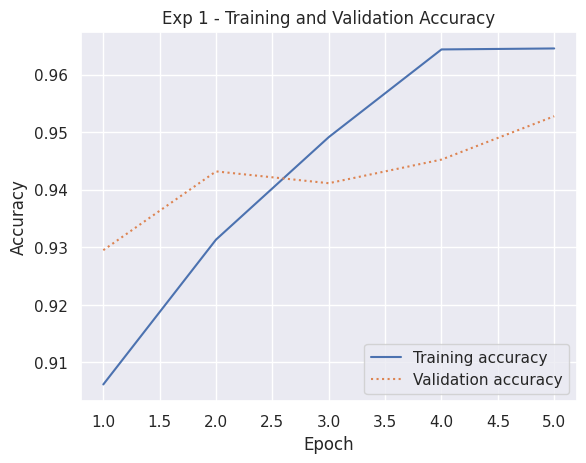

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

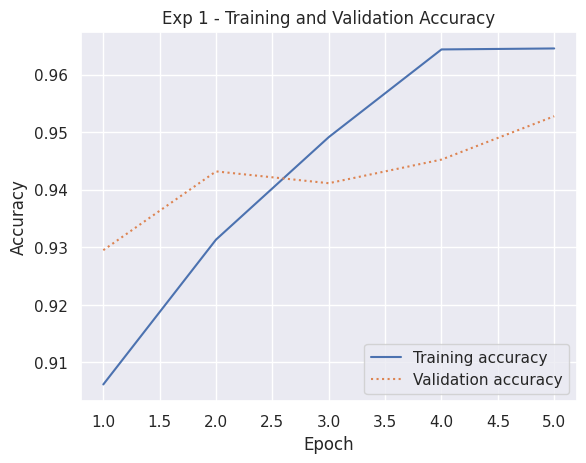

In [ ]:
gerarGraficoAcuracia(hist,'Exp 1')

In [ ]:
calcularAUC('exp1',"04")

In [ ]:
model.get_metrics_result()

In [ ]:
y_hat = model.predict(sequences_sample)


In [ ]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [ ]:
y_hat*100

In [ ]:
#y_sample

In [ ]:
pct_auc = roc_auc_score(y_sample, y_hat*100)*100.0
"{:0.2f}%".format(pct_auc)

To get a sense of where the model breaks down, we can create
a DataFrame of y and ŷ validation set values

In [ ]:
float_y_hat = []
for z in y_hat:
  float_y_hat.append(round(z[0]))

ydf = pd.DataFrame(list(zip(float_y_hat, y_sample)),
                   columns=['y_hat', 'y'])

ydf.head(32)